## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/solubility/solub_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_pubchem_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train = df_train_all['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

In [5]:
X_train.shape, y_train.shape

((1410, 881), (1410,))

In [6]:
X_test.shape, y_test.shape

((353, 881), (353,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,...,PubchemFP820,PubchemFP821,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP827,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP836
0,1,0,1,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,1,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
172,1,0,1,0,1,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
173,1,0,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
174,1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test

,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,...,PubchemFP820,PubchemFP821,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP827,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP836
0,1,0,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,1,1,0,1,1,...,0,1,0,0,0,1,0,0,0,0
3,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,1,0,0,1,1,...,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,0,0,0,1,1,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1
349,1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
350,1,1,1,1,1,1,1,0,1,1,...,0,1,0,1,0,0,0,0,0,0
351,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# write

with open('../../pubchem_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['solubility'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [9]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [11]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 50, 'solver': 'lsqr', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 0.6842381039605127
MSE: 0.7005108941645551
RMSE: 0.8369652885063724
R2 Square 0.23475414601685585 

Base model:
MAE: 0.6906639889729085
MSE: 0.7020661850134488
RMSE: 0.837893898422377
R2 Square 0.2330551290796915 

Train set:
Tuned model:
MAE: 0.5973202939533174
MSE: 0.5416290028631146
RMSE: 0.7359544842333081
R2 Square 0.4220336120842404 

Base model:
MAE: 0.6249224548246359
MSE: 0.5827123467772231
RMSE: 0.763355976446915
R2 Square 0.3781940249129101 



In [12]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [18]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 8, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 0.6272015280653621
MSE: 0.5871693299042482
RMSE: 0.7662697500908203
R2 Square 0.3585697252700595 

Base model:
MAE: 0.6055483046641679
MSE: 0.5577681271997689
RMSE: 0.7468387558233497
R2 Square 0.3906879245145606 

Train set:
Tuned model:
MAE: 0.5100825002906244
MSE: 0.38764961402394543
RMSE: 0.6226151411778752
R2 Square 0.5863433346257092 

Base model:
MAE: 0.33668565805722955
MSE: 0.17139045881187603
RMSE: 0.41399330768972104
R2 Square 0.8171111150269041 



In [10]:
params = {'max_depth': 8, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.6272015280653621
MSE: 0.5871693299042482
RMSE: 0.7662697500908203
R2 Square 0.3585697252700595 

Train set:
MAE: 0.5100825002906244
MSE: 0.38764961402394543
RMSE: 0.6226151411778752
R2 Square 0.5863433346257092 



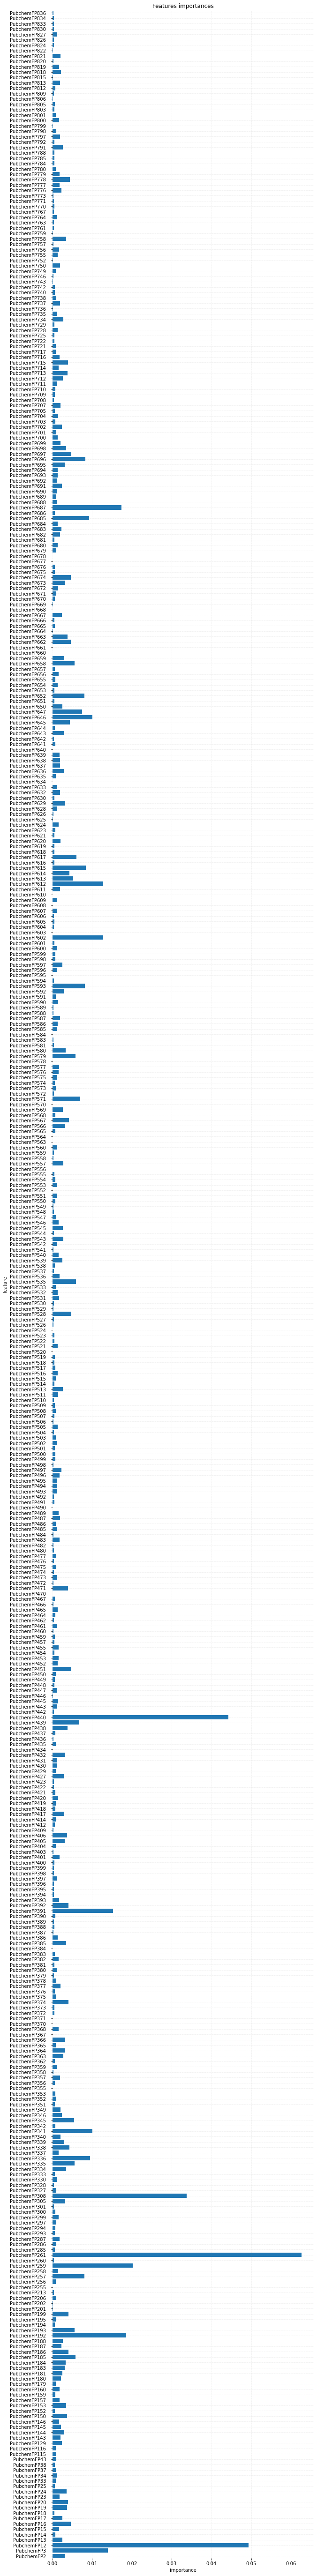

In [20]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [28]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [105, 110, 115],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 105, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.6383826835310074
MSE: 0.6222936139407871
RMSE: 0.788855889209675
R2 Square 0.32019956863581633 

Base model:
MAE: 0.6301790334469223
MSE: 0.6378514859324361
RMSE: 0.798656049831488
R2 Square 0.30320397707887303 

Train set:
Tuned model:
MAE: 0.5355294217661144
MSE: 0.43946803890583636
RMSE: 0.6629238560391656
R2 Square 0.5310484599085965 

Base model:
MAE: 0.2000450434056833
MSE: 0.07475075970140889
RMSE: 0.2734058516224715
R2 Square 0.9202342814911981 



In [29]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 105, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.6383826835310074
MSE: 0.6222936139407871
RMSE: 0.788855889209675
R2 Square 0.32019956863581633 

Train set:
MAE: 0.5355294217661144
MSE: 0.43946803890583636
RMSE: 0.6629238560391656
R2 Square 0.5310484599085965 



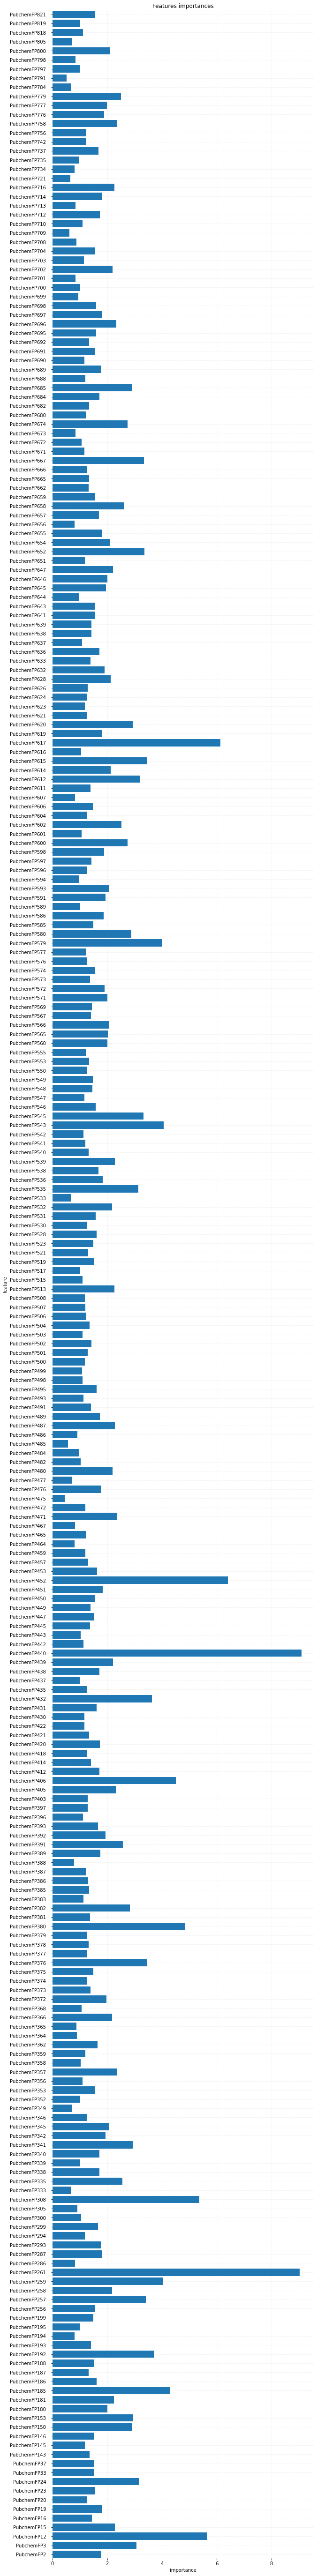

In [30]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [31]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200


## 5.4. LightGBM

Better results - third model.

In [48]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 2000],
    'min_child_samples': [30, 55, 65, 90],
    'reg_alpha': [1.7, 2.3, 2.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 90, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 2.7, 'reg_lambda': 0.04, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 0.6449173481935842
MSE: 0.636116560805583
RMSE: 0.7975691573810907
R2 Square 0.30509922848945803 

Base model:
MAE: 0.6325645738609336
MSE: 0.6072693604690622
RMSE: 0.7792748940323063
R2 Square 0.3366122294155479 

Train set:
Tuned model:
MAE: 0.5394193118784012
MSE: 0.4458697691455694
RMSE: 0.6677348045036813
R2 Square 0.5242172435529158 

Base model:
MAE: 0.312795871400431
MSE: 0.1573570092907517
RMSE: 0.3966825043920537
R2 Square 0.8320860555984899 



In [49]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 90, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 2.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.6410721739458182
MSE: 0.6288385426631615
RMSE: 0.7929934064436863
R2 Square 0.313049816060754 

Train set:
MAE: 0.5392595289632632
MSE: 0.44606905068401786
RMSE: 0.6678840099029306
R2 Square 0.5240045924017651 



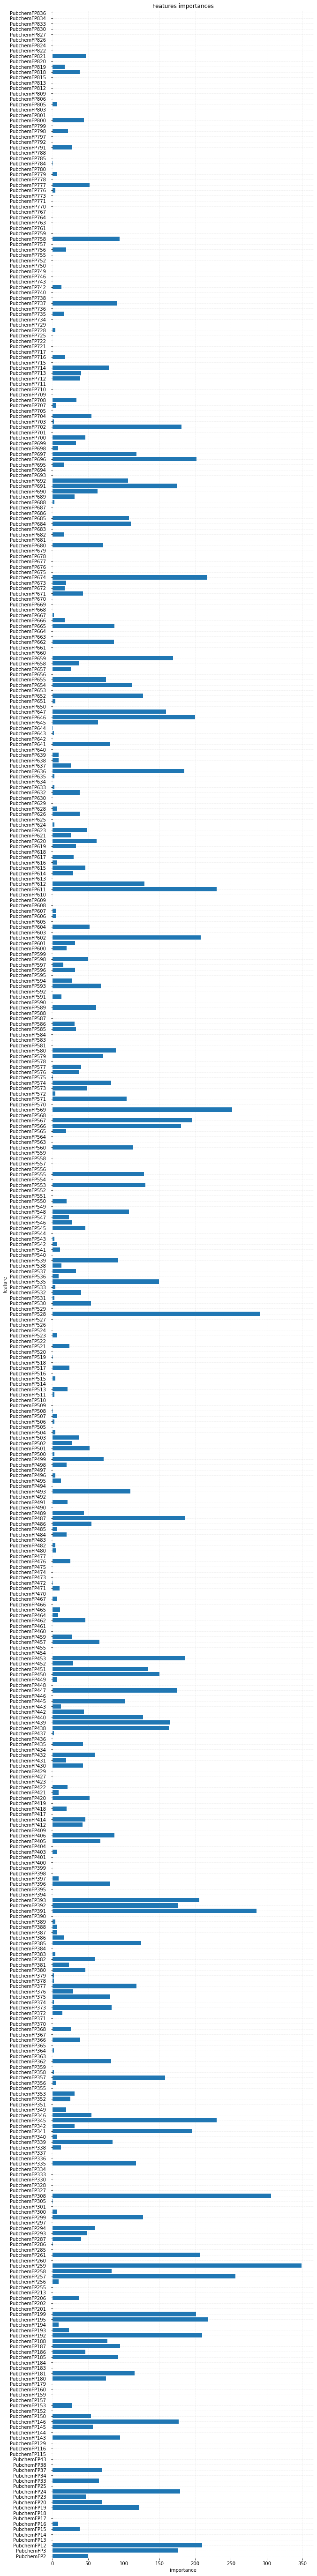

In [50]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [51]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200
3,LightGBM,0.641072,0.628839,0.792993,0.313050


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [72]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20} 

Test set:
Tuned model:
MAE: 0.6351831620041093
MSE: 0.6097892874884039
RMSE: 0.7808900610767202
R2 Square 0.33385943324927114 

Base model:
MAE: 0.6325645738917194
MSE: 0.6072693590501745
RMSE: 0.7792748931219166
R2 Square 0.3366122309655566 

Train set:
Tuned model:
MAE: 0.508382284609752
MSE: 0.3963630355985852
RMSE: 0.6295736935407842
R2 Square 0.5770453377177509 

Base model:
MAE: 0.3127958701577289
MSE: 0.15735700894932692
RMSE: 0.3966825039617035
R2 Square 0.8320860559628205 



In [73]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.6351831620041093
MSE: 0.6097892874884039
RMSE: 0.7808900610767202
R2 Square 0.33385943324927114 

Train set:
MAE: 0.508382284609752
MSE: 0.3963630355985852
RMSE: 0.6295736935407842
R2 Square 0.5770453377177509 



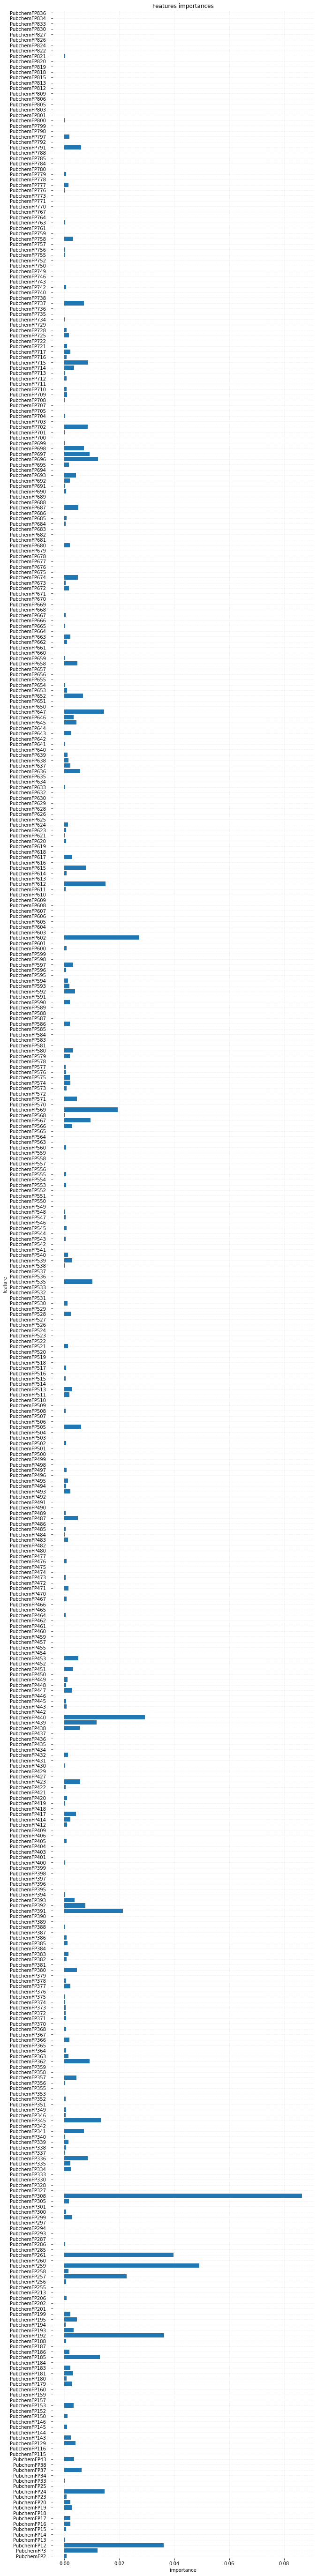

In [74]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [75]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200
3,LightGBM,0.641072,0.628839,0.792993,0.313050
4,HistGradient Boosting Regressor,0.635183,0.609789,0.780890,0.333859


## 5.6. Support Vector Regression

Better results - fifth model.

In [87]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [5.0, 10.0, 15.0],
    'epsilon': [0.9, 1.2, 1,7, 2,7],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 5.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.668096280455935
MSE: 0.6371190539693367
RMSE: 0.798197377826648
R2 Square 0.30400409386186045 

Base model:
MAE: 0.6551643791948465
MSE: 0.6608869033923869
RMSE: 0.8129495085135281
R2 Square 0.27803983209148997 

Train set:
Tuned model:
MAE: 0.5745605141091894
MSE: 0.42935354583171426
RMSE: 0.6552507503480742
R2 Square 0.541841524897265 

Base model:
MAE: 0.4735782507023119
MSE: 0.40530429108194316
RMSE: 0.6366351318313679
R2 Square 0.5675042217364592 



In [88]:
params = {'C': 5.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.668096280455935
MSE: 0.6371190539693367
RMSE: 0.798197377826648
R2 Square 0.30400409386186045 

Train set:
MAE: 0.5745605141091894
MSE: 0.42935354583171426
RMSE: 0.6552507503480742
R2 Square 0.541841524897265 



In [90]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [91]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200
3,LightGBM,0.641072,0.628839,0.792993,0.313050
4,HistGradient Boosting Regressor,0.635183,0.609789,0.780890,0.333859
5,Support Vector Regression,0.668096,0.637119,0.798197,0.304004


### Save models

In [11]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''
pickle.dump(rf_best, open('../../models/solub_pubchem_rf_model.pkl', 'wb'))

## 5.7. Stacking models

### Averaging base models

In [97]:
def average_predictions(X):
    return ((0.30 * rf_best.predict(X)) + \
            (0.15 * xgbr_best.predict(X)) + \
            (0.15 * lgbm_best.predict(X)) + \
            (0.25 * hist_best.predict(X)) + \
            (0.15 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.6302619723117874
MSE: 0.59192157296581
RMSE: 0.7693643954367853
R2 Square 0.3533783223521684 

Train set:
MAE: 0.5186474778854343
MSE: 0.3943494563911056
RMSE: 0.6279724965244143
R2 Square 0.5791940060777858 



In [98]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200
3,LightGBM,0.641072,0.628839,0.792993,0.313050
4,HistGradient Boosting Regressor,0.635183,0.609789,0.780890,0.333859
5,Support Vector Regression,0.668096,0.637119,0.798197,0.304004
6,Averaging base models,0.630262,0.591922,0.769364,0.353378


### Averaging base models with Meta-model

In [99]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [100]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.512694,4.879423,4.865191,4.895067,4.421380
1,4.669042,4.718773,4.682205,4.638774,4.673126
2,4.194912,3.948550,4.036562,4.219138,4.191888
3,4.406857,4.370749,4.349802,4.183904,4.641717
4,4.909136,5.273376,5.340816,5.112552,5.267104
...,...,...,...,...,...
1405,5.396875,5.423807,5.438568,5.317137,5.428357
1406,3.710121,3.729311,3.674775,3.935281,4.169222
1407,4.503620,4.247926,4.313369,4.197962,4.143390
1408,4.850857,4.787243,4.777110,4.906069,4.923456


In [107]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.6073967124393033
MSE: 0.573967726185741
RMSE: 0.7576065774435574
R2 Square 0.37299130328643637 

Train set:
MAE: 0.4353879197690063
MSE: 0.2767149888354825
RMSE: 0.5260370603251091
R2 Square 0.7047204604369883 



In [108]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200
3,LightGBM,0.641072,0.628839,0.792993,0.313050
4,HistGradient Boosting Regressor,0.635183,0.609789,0.780890,0.333859
5,Support Vector Regression,0.668096,0.637119,0.798197,0.304004
6,Averaging base models,0.630262,0.591922,0.769364,0.353378
7,Base models + Meta-model,0.607397,0.573968,0.757607,0.372991


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [109]:
params_rf = {'max_depth': 8, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 105, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 90, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 2.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}   

params_svr = {'C': 5.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'} 

In [110]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.6914388097748727
Model1 R2: 0.2674125742543725
Model2 MSE: 0.7241927144319311
Model2 R2: 0.2327094329834266
Model3 MSE: 0.6957772701771717
Model3 R2: 0.2628159252192187
Model4 MSE: 0.6931312962646462
Model4 R2: 0.2656193652196409
Model5 MSE: 0.7507591675749479
Model5 R2: 0.20456196824164963
Average MSE = 0.7110598516447139
Average R2 = 0.24662385318366162
-------------- fold 2 --------------
Model1 MSE: 0.6107246564524419
Model1 R2: 0.31501807883508726
Model2 MSE: 0.6012010672238536
Model2 R2: 0.3256996296407766
Model3 MSE: 0.6058004902789674
Model3 R2: 0.32054096835658563
Model4 MSE: 0.5992967882287995
Model4 R2: 0.32783544759193495
Model5 MSE: 0.6603826804622769
Model5 R2: 0.2593221963647536
Average MSE = 0.6154811365292678
Average R2 = 0.30968326415782765
-------------- fold 3 --------------
Model1 MSE: 0.6700213989348158
Model1 R2: 0.31897909311663075
Model2 MSE: 0.6198441280868094
Model2 R2: 0.36998010674420634
Model3 MSE: 0.61029

In [111]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [112]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [113]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.542094,4.793897,4.842977,4.760293,4.623920
1,4.612987,4.611504,4.678654,4.612380,4.729777
2,4.149632,3.942310,3.976988,4.168738,4.156210
3,4.355062,4.294327,4.207050,4.243805,4.611669
4,4.507573,5.043328,5.032596,4.991857,5.204582
...,...,...,...,...,...
1405,5.418979,5.469839,5.537046,5.381395,5.340744
1406,3.847958,3.860996,3.786268,3.868418,4.511321
1407,4.329796,3.976856,4.144290,4.074259,4.047048
1408,4.606518,4.595660,4.643408,4.866261,4.506433


In [114]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.400700,4.459283,4.565236,4.603723,4.466179
1,4.449666,4.748331,4.683260,4.210607,4.571460
2,4.921805,4.790159,4.777158,4.886508,4.731264
3,4.851801,4.768337,4.816267,4.812764,5.087499
4,4.309524,4.523827,4.535519,4.574129,4.368409
...,...,...,...,...,...
348,4.303778,3.768590,3.892632,4.025431,4.034544
349,5.455668,5.585364,5.509626,5.552187,5.549015
350,4.224537,4.276023,4.186492,4.038561,4.065718
351,4.506644,4.379171,4.302303,4.614962,4.490489


In [115]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.6236060732348436
MSE: 0.5937247538471391
RMSE: 0.7705353683297991
R2 Square 0.3514085075999448 

Train set:
MAE: 0.6384643472165321
MSE: 0.6269785216110544
RMSE: 0.7918197532336854
R2 Square 0.3309580736615645 



In [116]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.684238,0.700511,0.836965,0.234754
1,Random Forest Regressor,0.627202,0.587169,0.766270,0.358570
2,XGBoost,0.638383,0.622294,0.788856,0.320200
3,LightGBM,0.641072,0.628839,0.792993,0.313050
4,HistGradient Boosting Regressor,0.635183,0.609789,0.780890,0.333859
5,Support Vector Regression,0.668096,0.637119,0.798197,0.304004
6,Averaging base models,0.630262,0.591922,0.769364,0.353378
7,Base models + Meta-model,0.607397,0.573968,0.757607,0.372991
8,Base models + Meta-model + cv,0.623606,0.593725,0.770535,0.351409
